# Pipeline example

In [15]:
%matplotlib inline

In [16]:
import sys
import errno
import os
import os.path as op
import cPickle as pickle
import wrappers as wr
from pipeline import pipefuncs as pf
from pipeline import _make_networkx as mn
from mayavi import mlab
from IPython.display import Image
from mombud.vtk_viz import vtkvizfuncs as vf
mlab.options.offscreen = True

Working directory for input and output data

In [17]:
datadir = op.join(os.getcwd(),'data', 'pipeline')

The pipeline starts with taking the skeletonized data output from MitoGraph v2.0 along with the raw 3D volume data in both channels (GFP and RFP) along with the surface file

In [18]:
try:
    with open(op.join(datadir, 'fileMetas.pkl'), 'rb') as inpt:
        filemetas = pickle.load(inpt)
except IOError:
    print "Error: Make sure you have file metadatas in working directory"

try:
    vtkSkel = wr.swalk(datadir, '*skeleton.vtk', stop=-13)
    vtkVolRfp = wr.swalk(datadir, '*RF*resampled.vtk', stop=-14)
    vtkVolGfp = wr.swalk(datadir, '*GF*resampled.vtk', stop=-14)
    vtkSurf =  wr.swalk(datadir, '*urface*.vtk', stop=-12)
except Exception:
    print "Error: check your filepaths"
    sys.exit()

key = '052315_009_RFPstack_012'


The skeleton has no scalar values yet

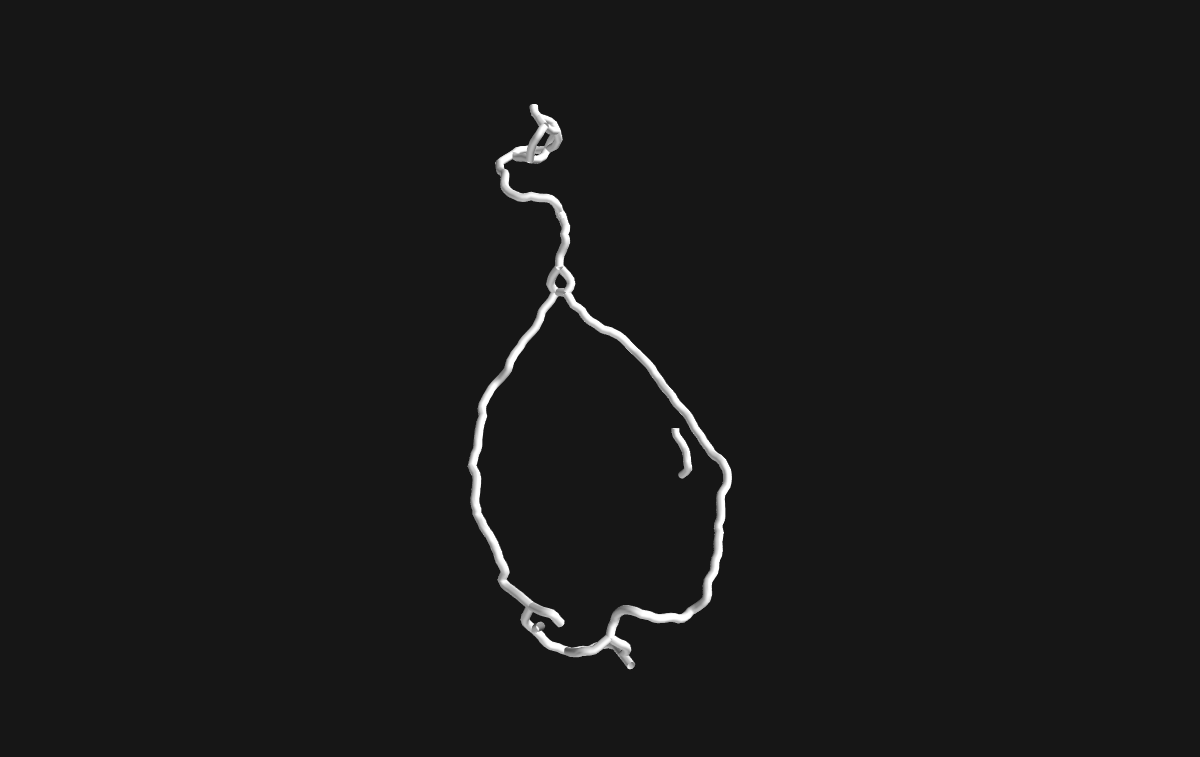

In [19]:
figone = mlab.figure(figure=key,
                     size=(1200, 800),
                     bgcolor=(.086, .086, .086))
vtkobj, vtktube = vf.cellplot(figone,
                              vtkSkel[key],
                              scalartype='Width',
                              rad=.06)
vtktube.actor.mapper.scalar_visibility = False
mlab.savefig(op.join(datadir, 'bare' + '.png'))
mlab.close(figone)
Image(filename=op.join(datadir, 'bare' + '.png'))

We calculate scalar values using a point cloud averaging along every pixel in the skeleton. A graph network is also calculated from by examining the end point of each line segment in the skeleton for coincident points. 

In [20]:
data = pf.add_scalars(vtkSkel[key],
                      vtkVolRfp[key],
                      vtkVolGfp[key.replace('RFP', 'GFP')])
filename = op.join(datadir, 'Norm_%s_skeleton.vtk' % key)
nm, rw, rb, gb, wq = pf.normSkel(data, filemetas['YPD_'+key])
calc = {'DY_minmax': nm,
        'DY_raw': rw,
        'bkstRFP': rb,
        'bkstGFP': gb,
        'WidthEq': wq}
pf.writevtk(data, filename, **calc)
vtkNorm = wr.swalk(op.join(datadir, ),
                   'N*Skeleton.vtk', start=5, stop=-13)
# render the various skeleton heatmaps offscreen as Mayavi doesnt allow easy inline plotting in Ipython
for t in calc:
    figone = mlab.figure(figure=key,
                         size=(1200, 800),
                         bgcolor=(.086, .086, .086))
    _, vtktube = vf.cellplot(figone,
                                  vtkNorm[key],
                                  scalartype=t,
                                  rad=.08)
    mlab.savefig(op.join(datadir, t + '.png'))
    mlab.close(figone)

Raw heatmap of function (mito. membrane potential ΔΨ).

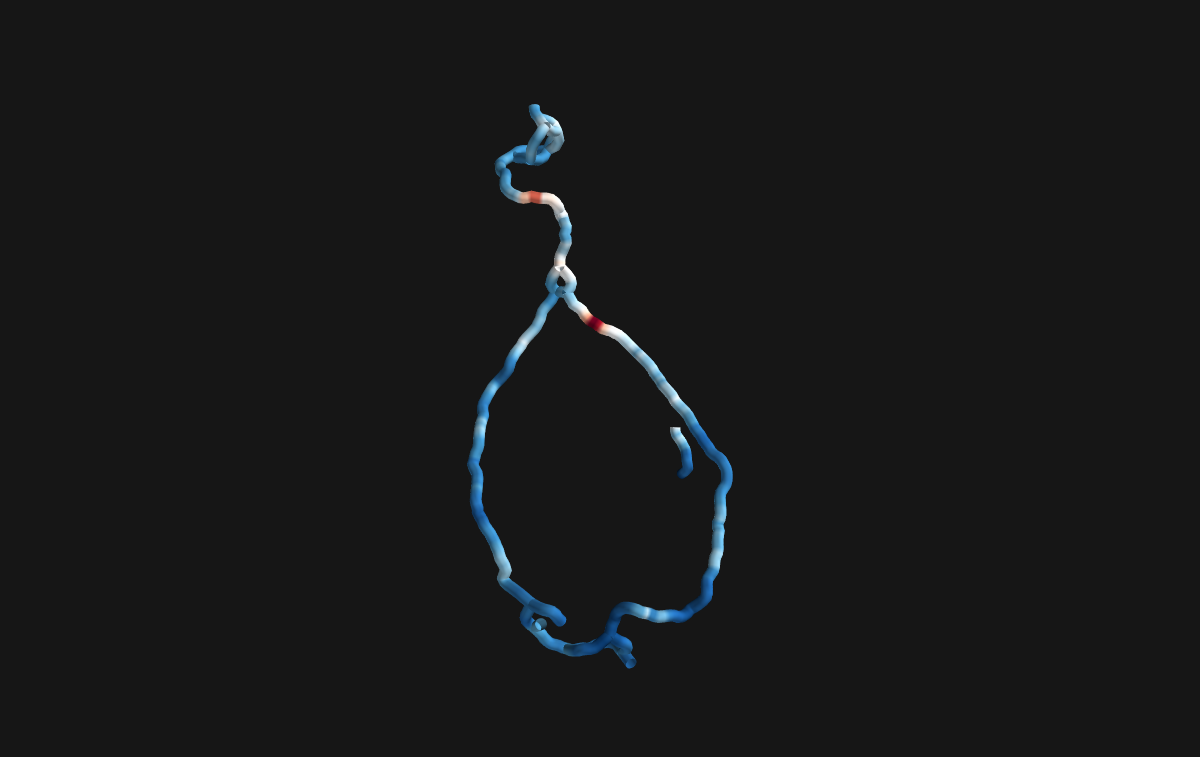

In [21]:
Image(filename=op.join(datadir, 'DY_raw' + '.png'))

The network has can now be viewed as a weighted graph with branchpoints (magenta dots) and end points (cyan dots).

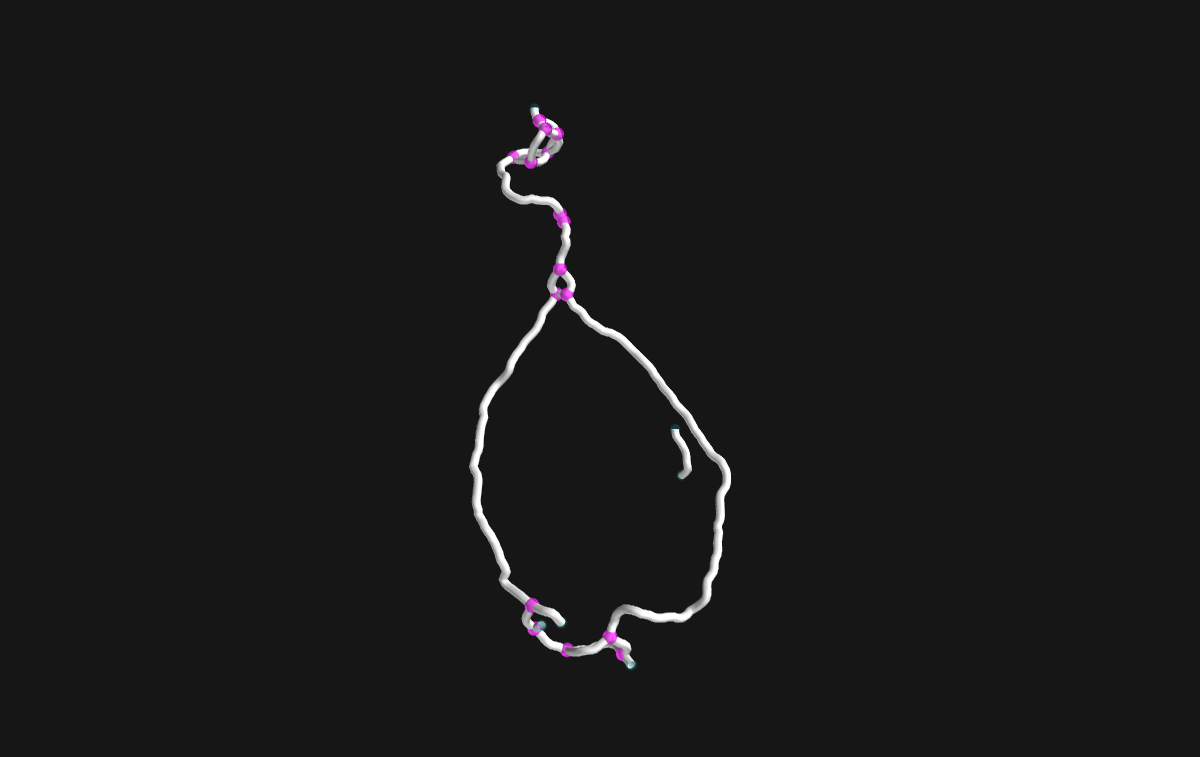

In [23]:
figone = mlab.figure(figure=key,
                     size=(1200, 800),
                     bgcolor=(.086, .086, .086))
vtkobj, vtktube = vf.cellplot(figone,
                              vtkNorm[key],
                              rad=.06)
vtktube.actor.mapper.scalar_visibility = False
_, _, nxgrph = mn.makegraph(vf.callreader(vtkNorm[key]), key)
vf.labelbpoints(nxgrph, bsize=.10, esize=0.08)
mlab.savefig(op.join(datadir, 'bare2' + '.png'))
mlab.close(figone)
Image(filename=op.join(datadir, 'bare2' + '.png'))